In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [3]:
path_data = '../data/raw/ParisHousing.csv'
raw_data = pd.read_csv(path_data)

raw_data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [16]:
y = raw_data.price
X = raw_data.drop(columns='price')

X_train, X_val,y_train, y_val = train_test_split(X,y)

def first_test_tree(n):
    model =RandomForestRegressor(n_estimators=n,random_state=1)
    model.fit(X_train,y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(preds, y_val)
    return mae

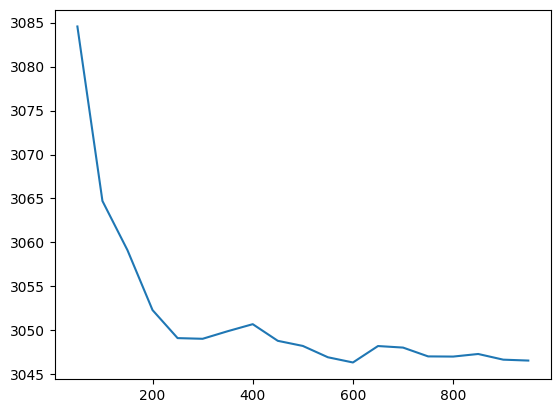

In [21]:
plt.figure()

X = [50*n for n in range(1,20)]
Y = [first_test_tree(n) for n in X]

plt.plot(X,Y)
plt.show()

In [22]:
imp = SimpleImputer()
model_1 = RandomForestRegressor(random_state=1)
pipe_1 = Pipeline([
    ('preprocessor', imp),
    ('model', model)
])

def mae_1(X_rain=X_train,y_train=y_train,X_val=X_val,y_val=y_val):
    scores = cross_val_score(pipe_1, X_train, y_train,
                             scoring='negative_absolute_error',
                             cv=10)
    return scores.mean()

mae_1() 


NameError: name 'SimpleImputer' is not defined